## Get the CelebA DataSet to train the DRL model

In [ ]:
!mkdir data

In [ ]:
cd data

In [ ]:
!gdown https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM

In [ ]:
!unzip img_align_celeba.zip

In [ ]:
!rm img_align_celeba.zip

In [ ]:
cd ..

## Train Renderer

In [15]:
!python train_renderer.py --constrained=True

^C


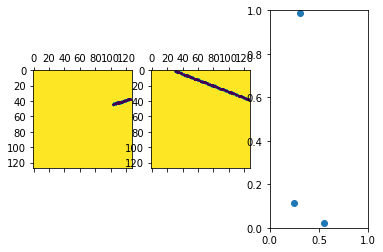

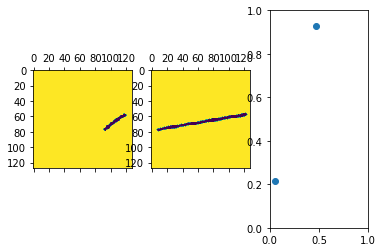

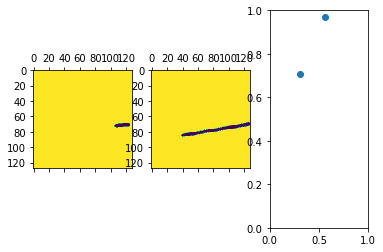

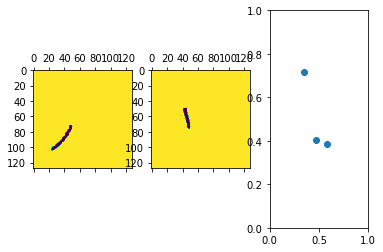

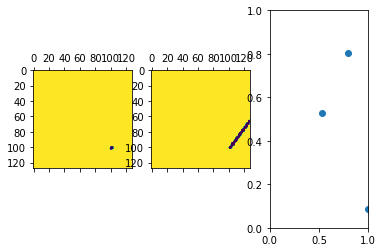

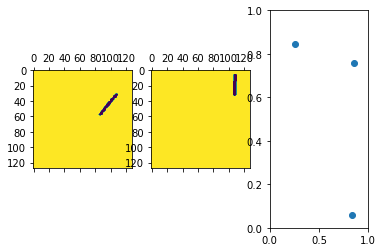

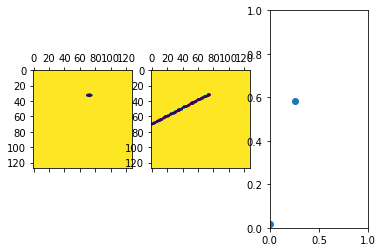

In [62]:
import cv2
import numpy as np

MAX_ITERATIONS = 100

def normal(x, width):
    return (int)(x * (width - 1) + 0.5)

def draw(f, width=128, max_brush_width=None, opacity=None, max_length=None):
    x0, y0, x1, y1, x2, y2, z0, z2, w0, w2 = f

    if max_brush_width is not None:
        z0, z2 = max_brush_width
    if opacity is not None:
        w0, w2 = opacity

    frac = 1. / MAX_ITERATIONS
    if max_length is not None:
        curve_length = bezier_curve_length(x0,y0, x1,y1, x2,y2)
        if curve_length > max_length:
            # Don't draw the full curve. Make the increment less by scaling.
            frac = frac * (max_length / curve_length)

    x1 = x0 + (x2 - x0) * x1
    y1 = y0 + (y2 - y0) * y1
    x0 = normal(x0, width * 2)
    x1 = normal(x1, width * 2)
    x2 = normal(x2, width * 2)
    y0 = normal(y0, width * 2)
    y1 = normal(y1, width * 2)
    y2 = normal(y2, width * 2)
    z0 = (int)(1 + z0 * width // 2)
    z2 = (int)(1 + z2 * width // 2)
    canvas = np.zeros([width * 2, width * 2]).astype('float32')
    
    for i in range(MAX_ITERATIONS):
        t = i * frac
        x = (int)((1-t) * (1-t) * x0 + 2 * t * (1-t) * x1 + t * t * x2)
        y = (int)((1-t) * (1-t) * y0 + 2 * t * (1-t) * y1 + t * t * y2)
        z = (int)((1-t) * z0 + t * z2)
        w = (1-t) * w0 + t * w2
        cv2.circle(canvas, (y, x), z, w, -1)
    return 1 - cv2.resize(canvas, dsize=(width, width))

'''https://malczak.linuxpl.com/blog/quadratic-bezier-curve-length/'''
def bezier_curve_length(x0,y0, x1,y1, x2,y2):
    ax = x0 - 2*x1 + x2
    ay = y0 - 2*y1 + y2

    bx = 2*x1 - 2*x0
    by = 2*y1 - 2*y0

    A = max(4*(ax**2 + ay**2), 1e-7)
    B = max(4*(ax*bx + ay*by), 1e-7)
    C = max(bx**2 + by**2, 1e-7)

    Sabc = 2*(A + B + C)**(1/2)
    A_2 = A**(1/2)
    A_32 = 2*A*A_2
    C_2 = 2*C**(1/2)
    BA = B/A_2

    return ( A_32*Sabc + \
          A_2*B*(Sabc-C_2) + \
          (4*C*A-B*B)*np.log( (2*A_2+BA+Sabc)/(BA+C_2) ) \
        )/(4*A_32);
import matplotlib.pyplot as plt

fs = [
     [0,0,  0.5, 0.5,   1,1,   0,0,0,0],
     [0,0,  1, 0,   .3,.3,   0,0,0,0],
     [0,0,  1,0,   0.5,1,   0,0,0,0],
     ]
ml = 0.3*2
for i in range(7):
    f = np.random.uniform(0, 1, 10)
    m0 = draw(f, width=128, max_brush_width=(0.05,0.05), opacity=(1.,1.), max_length=0.3)
    #f[2:4] = np.clip(f[0:1] + np.random.uniform(-1*ml, ml, 2), a_min=0, a_max=1)
    f[4:6] = np.clip(f[0:1] + np.random.uniform(-1*ml, ml, 2), a_min=0, a_max=1)
    
    mid_point = (f[0:1] + f[4:6]) / 2
    m = (f[6] - f[1]) / (f[5] - f[0])
    m_perp = -1. / m
    
    x1 = np.random.uniform(f[0], f[5], 1)[0] + np.random.uniform(-1*ml, ml, 1)[0]
#     x1 = np.random.uniform(0,1,1)[0]
    y1 = m_perp * (x1 - mid_point[0]) + mid_point[1]
    f[2:4] = np.array(x1, y1)
    
    m1 = draw(f, width=128, max_brush_width=(0.05,0.05), opacity=(1.,1.), max_length=None)
    fig, ax = plt.subplots(1,3)
    ax[0].matshow(m0)
    ax[2].scatter(x=[f[0], f[3],f[5]], y=[f[1],f[4],f[6]])
    plt.xlim(0, 1)
    plt.ylim(0,1)
    ax[1].matshow(m1)
    plt.show()
    